In [1]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00


In [1]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

In [3]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [4]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [5]:
def generate_with_embs(text_embeddings, seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [25]:
prompt = 'man sipping wine in spacesuit on moon'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [26]:
for t in text_input['input_ids'][0][:20]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))


tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-18-d10c6aa329ea>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

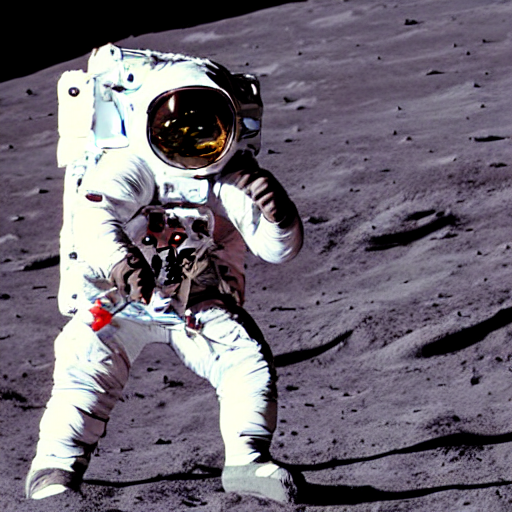

In [29]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings, 30)

In [ ]:
def generate_with_prompt_style(prompt, style, seed):
    embed = torch.load(style)

    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    for t in text_input['input_ids'][0][:20]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
        print(t, tokenizer.decoder.get(int(t)))
    input_ids = text_input.input_ids.to(torch_device)

    token_embeddings = token_emb_layer(input_ids)
    # The new embedding - our special birb word
    replacement_token_embedding = embed[list(embed.keys())[0]].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==338)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    generate_with_embs(modified_output_embeddings, seed)

In [ ]:
prompt = 'man sipping wine in spacesuit on moon in style of s'

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-18-d10c6aa329ea>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

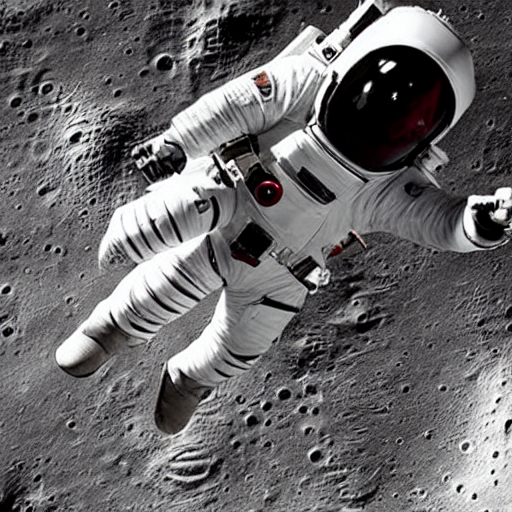

In [36]:
generate_with_prompt_style(prompt, 'learned_embeds_arcane.bin', 20)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-18-d10c6aa329ea>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

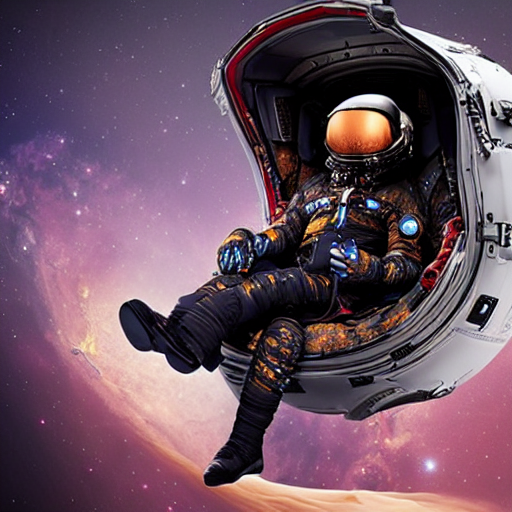

In [41]:
generate_with_prompt_style(prompt, 'learned_embeds_dr_strange.bin', 25)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-18-d10c6aa329ea>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

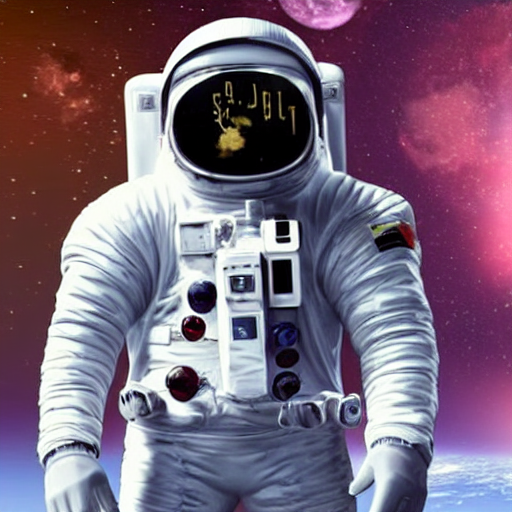

In [42]:
generate_with_prompt_style(prompt, 'learned_embeds_gta5.bin', 30)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-18-d10c6aa329ea>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

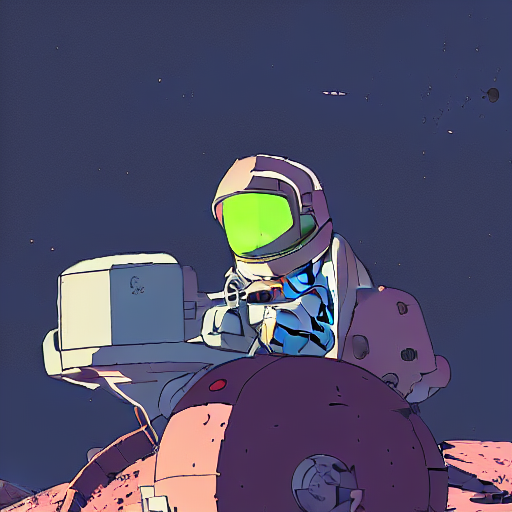

In [43]:
generate_with_prompt_style(prompt, 'learned_embeds_illustration.bin', 35)

tensor(49406) <|startoftext|>
tensor(786) man</w>
tensor(28527) sipping</w>
tensor(2604) wine</w>
tensor(530) in</w>
tensor(7857) space
tensor(3940) suit</w>
tensor(525) on</w>
tensor(3293) moon</w>
tensor(530) in</w>
tensor(1844) style</w>
tensor(539) of</w>
tensor(338) s</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


<ipython-input-18-d10c6aa329ea>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

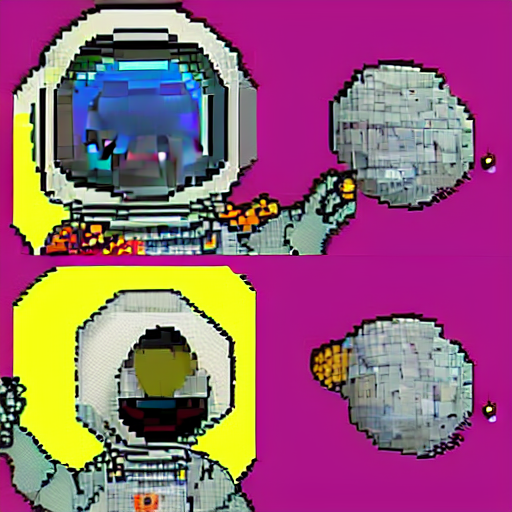

In [44]:
generate_with_prompt_style(prompt, 'learned_embeds_pokemon.bin', 40)

In [12]:
import torch

def contrast_loss(images):
    variance = torch.var(images)
    return -variance


<ipython-input-15-c258afbab977>:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -9.300140380859375
10 loss: -18.19939613342285
20 loss: -19.2166748046875
30 loss: -22.95360565185547
40 loss: -23.827831268310547


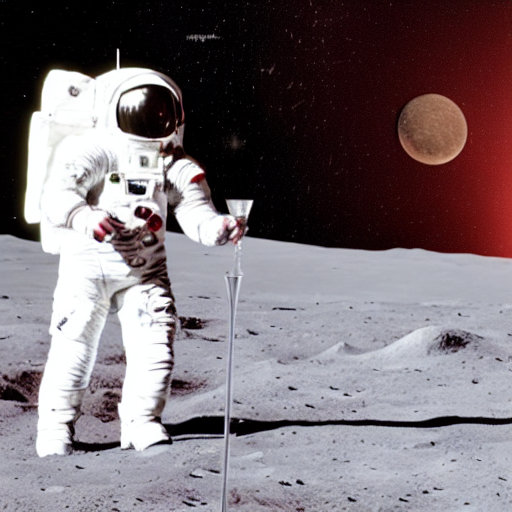

In [15]:
prompt = 'man sipping wine in spacesuit on moon'
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50       # Number of denoising steps
guidance_scale = 8           # Scale for classifier-free guidance
generator = torch.manual_seed(30)   # Seed generator to create the inital latent noise
batch_size = 1
contrast_loss_scale = 200

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        latents_x0 = latents - sigma * noise_pred
        # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = contrast_loss(denoised_images) * contrast_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [ ]:
def generate_with_prompt_style_guidance(prompt, style, seed):
    embed = torch.load(style)

    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50  #           # Number of denoising steps
    guidance_scale = 8 #               # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    contrast_loss_scale = 200 #

    # Prep text
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    input_ids = text_input.input_ids.to(torch_device)

    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)

    # The new embedding - our special birb word
    replacement_token_embedding = embed[list(embed.keys())[0]].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==338)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if i%5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

            # Calculate loss
            loss = contrast_loss(denoised_images) * contrast_loss_scale

            # Occasionally print it out
            if i%10==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    latents_to_pil(latents)[0]

<ipython-input-21-ccf8bde55ad8>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -11.283122062683105
10 loss: -19.62204360961914
20 loss: -27.143150329589844
30 loss: -30.8992977142334
40 loss: -31.62030601501465


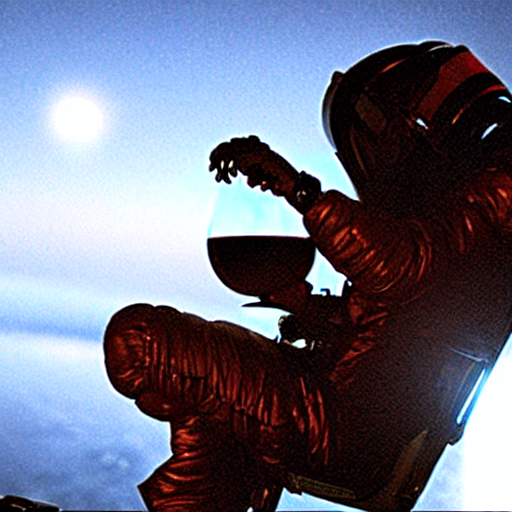

In [21]:
generate_with_prompt_style_guidance(prompt, 'learned_embeds_arcane.bin', 20)

<ipython-input-22-ae155d75efb9>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -5.931544303894043
10 loss: -14.830526351928711
20 loss: -22.35018539428711
30 loss: -24.434589385986328
40 loss: -26.201919555664062


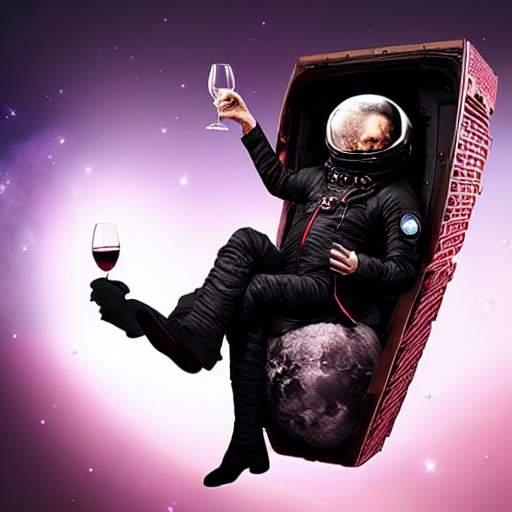

In [22]:
generate_with_prompt_style_guidance(prompt, 'learned_embeds_dr_strange.bin', 25)

<ipython-input-23-1a2d802c1f60>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -7.8176751136779785
10 loss: -15.540226936340332
20 loss: -20.207725524902344
30 loss: -23.831829071044922
40 loss: -26.37600326538086


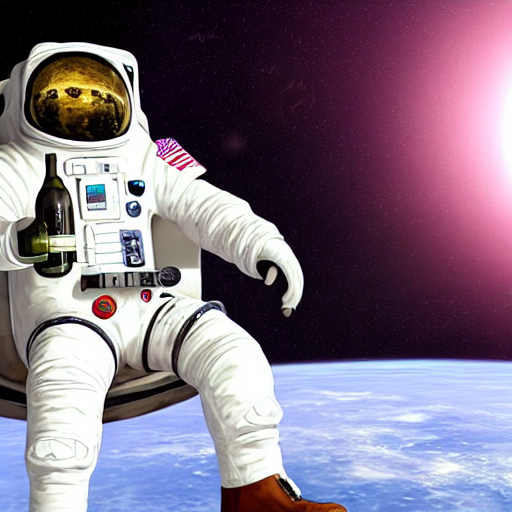

In [23]:
generate_with_prompt_style_guidance(prompt, 'learned_embeds_gta5.bin', 30)

<ipython-input-24-caa3f5b1ec68>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -7.766468048095703
10 loss: -13.224031448364258
20 loss: -15.811384201049805
30 loss: -18.530609130859375
40 loss: -19.995256423950195


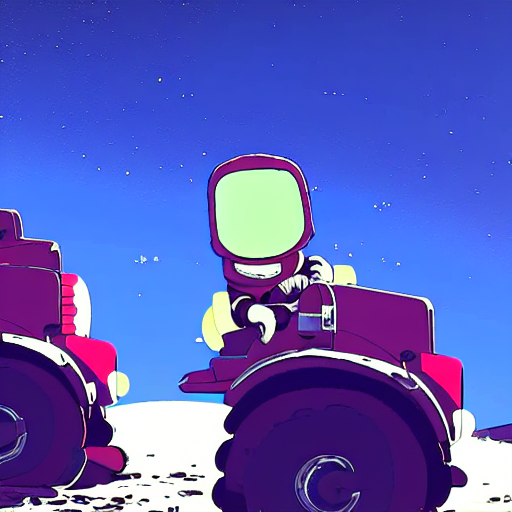

In [24]:
generate_with_prompt_style_guidance(prompt, 'learned_embeds_illustration.bin', 35)

<ipython-input-25-2d172d36fe33>:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -14.74111270904541
10 loss: -15.590971946716309
20 loss: -25.299129486083984
30 loss: -29.748939514160156
40 loss: -31.964475631713867


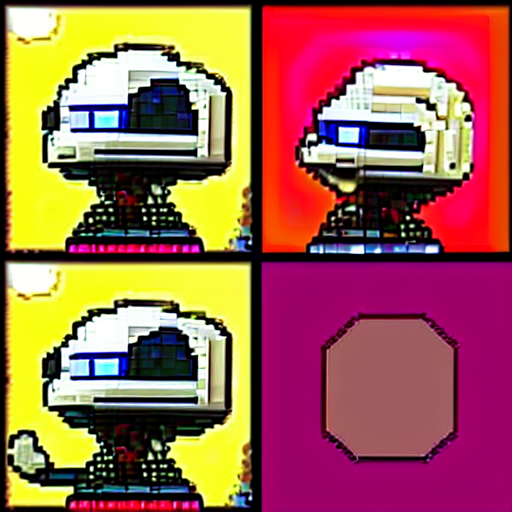

In [25]:
generate_with_prompt_style_guidance(prompt, 'learned_embeds_pokemon.bin', 40)